# Brightness profiles for the deconvolved data and initial polarimetric images

- radial profiles and check for the order of PSF smearing correction and deconvolution
- test for the possibility of calculation scattered light persentage from total intensity image

This scipt is adjusted to ZIMPOL data, but with slight modification can be used for IRDIS as well


## Functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from numpy import asarray as ar,exp

def plot_with_same_color(data, keys, labels,title,star,lim1,arcsinh,cameras):
    print("THe name is ", star)
    #min and max values setted manually here to 0 and 1
    num_keys = len(keys)
    ncols = int(np.ceil(np.sqrt(num_keys)))  # Adjust the number of rows as needed
    nrows = int(np.ceil(num_keys / ncols))
    fig = plt.figure(figsize=(12, 8))
    data_arcshin={}
    for idx, key in enumerate(keys):
        if arcsinh==True:
            data_arcshin[key] =np.arcsinh(data[key]) 
        else:
            data_arcshin[key] = data[key]
    # Using GridSpec to create a more flexible subplot layout
       
    gs = GridSpec(nrows, ncols, figure=fig, wspace=0.1, hspace=0.25)
    # Calculate vmin and vmax for all images
    n = data_arcshin[key].shape[0]
    vmin = min(data_arcshin[key][int(n/2-lim1):int(n/2+lim1),int(n/2-lim1):int(n/2+lim1)].min() for key in keys)
    vmax =max(data_arcshin[key][int(n/2-lim1):int(n/2+lim1),int(n/2-lim1):int(n/2+lim1)].max() for key in keys)

    for idx, key in enumerate(keys):
        if cameras[idx]=='IRDIS':
            ps=12.27
            lim=lim1*1.0
        else:
            ps=3.6
            lim=lim1*12.27/3.6
            
        ax = fig.add_subplot(gs[idx])
        n = data_arcshin[key].shape[0]
        d = (n-1) * ps / 2
        im = ax.imshow(data_arcshin[key], extent=(-d, d, -d, d), vmin=vmin, vmax=vmax,origin='lower')
        #plotting contour
        levels=[np.max(data_arcshin[key])/4,np.max(data_arcshin[key])/2]
        CS=ax.contour(data_arcshin[key], levels=levels,colors=['pink','white'], extent=(-d, d, -d, d))
        ax.clabel(CS, inline=True, fontsize=10)
        
        ax.set_title(labels[key])
        ax.set_xlabel('mas')
        ax.set_ylabel('mas')
        ax.set_xlim(-lim * ps, lim * ps)
        ax.set_ylim(-lim * ps, lim * ps)
        ax.label_outer()

    # Create a common colorbar for all images
    cax = fig.add_axes([0.95, 0.22, 0.02, 0.55])  # Adjust the position of colorbar as needed
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(star+' '+title, fontsize=16)#,y=0.85)

    #specific_folder=figfolder+'models/'
    #try:
    # Create target Directory
    #   os.mkdir(specific_folder)
    #except FileExistsError:
    #    print("Directory " , specific_folder,  " already exists")
   
    #plt.savefig(specific_folder +star+'_'+title+".jpeg",bbox_inches='tight', pad_inches=0.1)
    #plt.show()

def LoadImage(dirdat,filename):
    dir =dirdat
    psfile =  filename
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            fit = hdulPSF[0].data

            
    return fit

def LoadImage_dec (dir,annulus):

    files = os.listdir(dir)
    for fil in files:
        if fnmatch.fnmatch(fil, '*'+annulus+'_decon.fits'):
            hdu = fits.open(dir+fil)
            image = hdu[0].data
            ps =3.6
            n=image.shape[0]
            d=(n-1)/2
            x = np.linspace(-d, d, n)
            y = np.linspace(-d, d, n)
            x2, y2 = np.meshgrid(x, y)
            R = np.sqrt(x2**2+y2**2)
    return image, R, x, y, d,x2,y2

def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")

def load_I(dirdat,camera):
    dir = dirdat
    qfile = '*sci'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            q = hdulq[0].data[1]
            iu = hdulq[0].data[2]
            u = hdulq[0].data[3]
            n=q.shape[0]
            i=(iq+iu)/2
            
    return iq,iu,i
   
def Loadimagespsf(star,dirdat,band):
    dir = dirdat
    qfile = '*_'+band+'_I_meancombined.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

                print(n)
    return image, n

def plotImage(image, lim):
    n = image.shape[0]
    
    fig, ax = plt.subplots()
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.colorbar()
    plt.tight_layout
    
def Loadimages_notdeconv(star,fittype,dirdat,band, extension):
    dir = dirdat
    print(dir)
    qfile = star+'_'+band+'_'+fittype+extension+'.fits'
    # if no fittype, i.e. using IRDIS, uncomment below
    # qfile = star+'_'+band+''+extension+'.fits'
    print(qfile)
    files = os.listdir(dir)
    # print(files)
    image=[]
    for file in files:
        # print(file)
        if fnmatch.fnmatch(file, qfile):
            print("MATCHED")
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                print(image[1,4])
                n = image.shape[0]
                
    return image, n

def Loadimages(dirdat,band, extension):
    dir = dirdat
    qfile = band+extension+'.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]
                
    return image, n

def create_dir(dirname):
    if not os.path.isdir(dirname):
        os.makedirs(dirname, exist_ok=True)


## Set up

In [2]:
stars=['01.SCI_UMon','01.SCI_AR_Pup']
ref_of_sci={'01.SCI_AR_Pup':'REF_HD75885','UMon':'HD71253','01.SCI_UMon':'01.SCI_UMon','V709_Car':'HD94680','HR4049_20190108':'HD96314','HR4049_20190107':'HD96314','HR4226':'HD98025',"HR4049_combined":'HD96314'} #the corresponding scientific targets, SPHERE proposals
disk_incl_pa={'01.SCI_AR_Pup':[75,45],'UMon':[25,144],'01.SCI_UMon':[25,144],'V709_Car':[34,13],'HR4049_20190108':[49,63],'HR4049_20190107':[49,63],"HR4049_combined":[49,63],'HR4226':[0,1]} #Kluska_2019 for HR4049 V709Car, UMon from Andrych2023, AR Pup...have to check, this are from my table, HR4226 - just circle
starnames = {'01.SCI_UMon':'U Mon','01.SCI_AR_Pup':'AR Pup'}

star = stars[0]

incl_pa=disk_incl_pa[star]
# fittypes=['1','2']
fittypes = ['1']
# band=['V','I']
band=['H']

camera='ZIMPOL'
camera='IRDIS'

# ps=3.6
ps = 12.23
dirdat0 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star
dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_tel/'+camera

figfolder=dirdat0+'/After_deconv/'+camera+'/'
create_dir(figfolder)

normlim=45


## Comparing the PSF smearing correction before and after deconvolution

PSF is from reference star


V
reference                      max_DoLP[%] max_Q_phi  max_PI     sumQ_phi/I[%] sumPI/I[%] 
deconvolved                    65.602     402.581     438.692    2.841      4.176       
deconvolved+smearing           667.076    10503.987   18033.588  9.657      21.756      
THe name is  01.SCI_AR_Pup, PSF smearing test AR Pup, V band


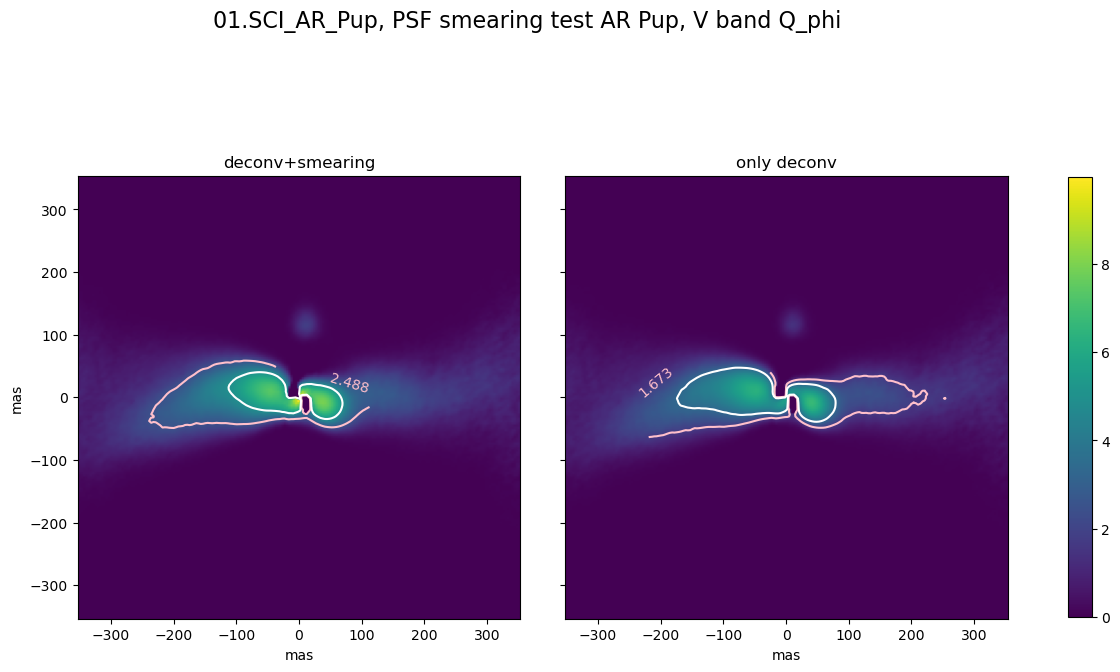

I
reference                      max_DoLP[%] max_Q_phi  max_PI     sumQ_phi/I[%] sumPI/I[%] 
deconvolved                    42.439     530.917     1029.746   3.307      4.159       
deconvolved+smearing           836.796    28349.709   47321.372  13.502     31.320      
THe name is  01.SCI_AR_Pup, PSF smearing test AR Pup, I band


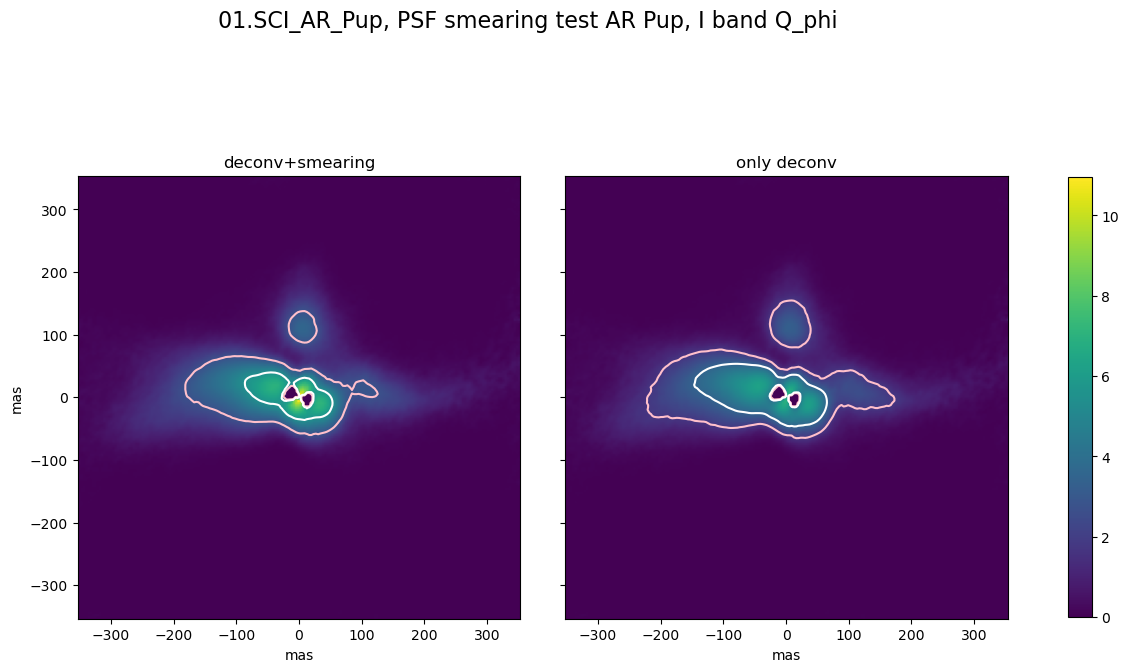

In [3]:
for fittype in fittypes:
    print(band[int(fittype)-1])
    output_filename = dirdat+star+'_'+band[int(fittype)-1]+'after_allcorr_stats.txt'
    with open(output_filename, 'w') as file_print:
        line="{:<30} {:<10} {:<10} {:<10} {:<10} {:<10} ".format('reference',"max_DoLP[%]", "max_Q_phi", "max_PI", "sumQ_phi/I[%]","sumPI/I[%]")
        #"{:<30} {:<10} {:<10} {:<10} {:<15}{:<10} {:<10} {:<10} {:<10}  \n".format('reference',"max_DoLP[%]", "max_Q_phi", "max_PI", 'Peak_I(Strehl)','Peak_PI','Peak_Qphi', "sumQ_phi/I[%]","sumPI/I[%]")

        print(line)
        file_print.write(line)

        dir =dirdat +'/deconvolved_'+'Q_phi'+'/'
        Q_phi_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
        dir =dirdat +'/deconvolved_'+'PI'+'/'
        PI_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])

        I=LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/',star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
        #PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+ref_of_sci[star]+'/filtered/',band[int(fittype)-1])

        frac =np.max(np.divide(Q_phi_decon,I,where=I!=0)*(R<=150))*100
        mask=(R<=normlim)
        qphi_sum=np.sum(Q_phi_decon[mask])
        I_sum=np.sum(I[R<=1500/ps])
        pi_sum=np.sum(PI_decon[mask])


        line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f}  ".format('deconvolved',
            frac, np.max(Q_phi_decon), np.max(PI_decon), qphi_sum/I_sum*100, pi_sum/I_sum*100)
        print(line)
        file_print.write(line)

        if star!='01.SCI_AR_Pup':
            f_q= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+ref_of_sci[star]+'/PSF_models/',ref_of_sci[star]+band[int(fittype)-1]+'band_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
            f_pi= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+ref_of_sci[star]+'/PSF_models/',ref_of_sci[star]+band[int(fittype)-1]+'band_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
        elif star=='01.SCI_AR_Pup':
            f_q= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+ref_of_sci[star]+'/PSF_models/',band[int(fittype)-1]+'band_qphi_circular_f_psf_50.fits')
            f_pi= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+ref_of_sci[star]+'/PSF_models/',band[int(fittype)-1]+'band_pi_circular_f_psf_50.fits')


        Q_phi_decon_smear=Q_phi_decon*f_q
        PI_decon_smear=PI_decon*f_pi

        frac =np.max(np.divide(Q_phi_decon_smear,I,where=I!=0)*(R<=150))*100
        mask=(R<=normlim)
        qphi_sum=np.sum(Q_phi_decon_smear[mask])
        pi_sum=np.sum(PI_decon_smear[mask])

        line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f}  ".format('deconvolved+smearing',
            frac, np.max(Q_phi_decon_smear), np.max(PI_decon_smear), qphi_sum/I_sum*100, pi_sum/I_sum*100)
        print(line)
        file_print.write(line)


        keys=['deconv+smearing','deconv']
        labels={'deconv+smearing':'deconv+smearing','deconv':'only deconv'}
        data={'deconv+smearing': Q_phi_decon_smear ,'deconv':Q_phi_decon}
        cameras=['ZIMPOL','ZIMPOL']
        plot_with_same_color(data, keys, labels ,'Q_phi',star+', PSF smearing test '+starnames[star]+', '+band[int(fittype)-1]+ ' band',8*ps,True,cameras)
        plt.savefig(figfolder+band[int(fittype)-1]+'band_qphi_decon+PSF_smear.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

        out_fits = fits.HDUList(fits.PrimaryHDU(Q_phi_decon_smear))                  # create output fits structure
        out_fits.writeto(figfolder+band[int(fittype)-1]+'band_qphi_decon+PSF_smear.fits', overwrite = True)                       # write output
        out_fits = fits.HDUList(fits.PrimaryHDU(PI_decon_smear))                  # create output fits structure
        out_fits.writeto(figfolder+band[int(fittype)-1]+'band_pi_decon+PSF_smear.fits', overwrite = True)                       # write output


In [4]:
figfolder

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/After_deconv/ZIMPOL/'

## Radial brightness profile

### Not Deconvolved

/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/ZIMPOL/
01.SCI_AR_Pup_V_Q_phi_meancombined.fits
MATCHED
1.0000000000000003e-16
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/ZIMPOL/
01.SCI_AR_Pup_V_PI_meancombined.fits
MATCHED
0.0
V


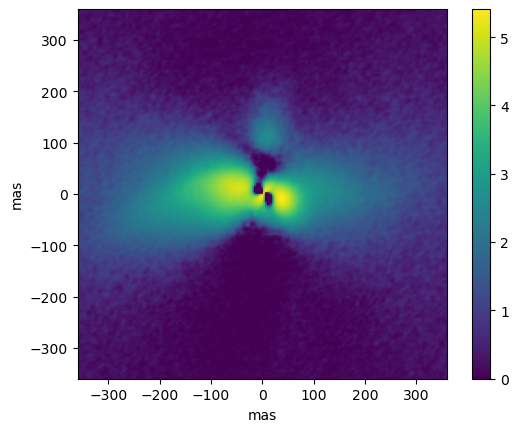

/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/ZIMPOL/
01.SCI_AR_Pup_I_Q_phi_meancombined.fits
MATCHED
1.0000000000000003e-16
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/ZIMPOL/
01.SCI_AR_Pup_I_PI_meancombined.fits
MATCHED
0.0


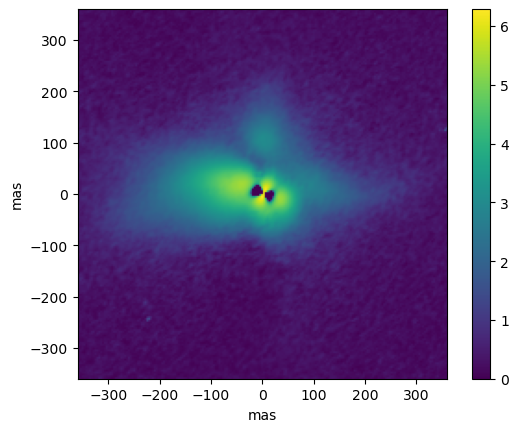

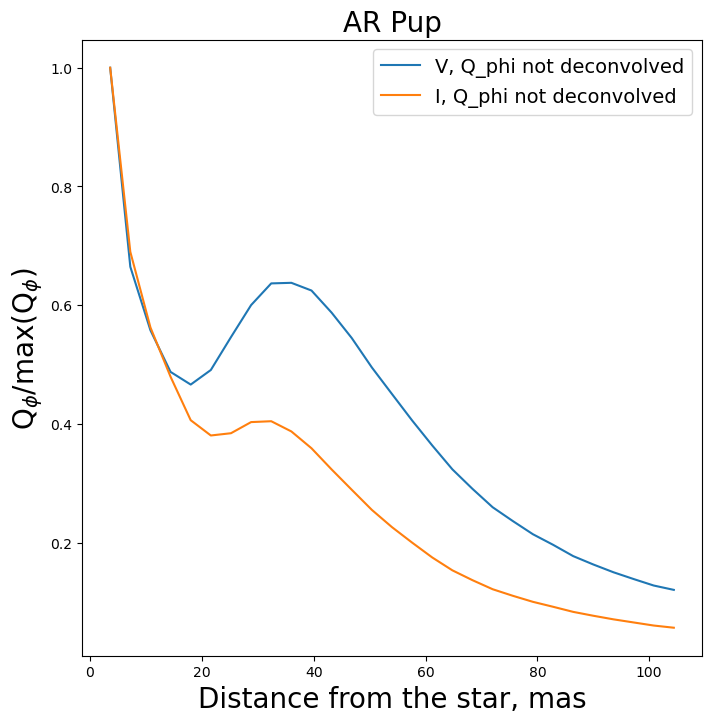

In [4]:

dirdat0 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/After_deconv/'+camera+'/'

dirdatI='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/'
figfolder=dirdat0
#dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/corr_with_ref/tel+unresol+PSF_smearing/Andrych2023/'  #For IRAS08
xc=511.5
yc=511.5

for fittype in fittypes:

    I=LoadImage(dirdatI,star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
    #PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/filtered/'+ref_of_sci[star]+'/',band[int(fittype)-1])

    Q_phi, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
    Q_phi, n=Loadimages_notdeconv(star,'Q_phi',dirdatI,band[int(fittype)-1],'_meancombined')


    mask=(R<=1500/ps)
    #PSF=PSF#/np.max(PSF[mask])#*np.sum(PSF[mask])/10e6
    norm=np.max(I[mask])

    #radial_brightness

    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-xc
    yr = yr-yc
    Xr, Yr = np.meshgrid(xr, yr)
    R=np.sqrt(Xr**2 + (Yr)**2)

    I_mean_ar=[]
    #PSF_mean_ar=[]
    PI_mean_ar=[]
    PI_unres_mean_ar=[]
    Q_phi_mean_ar=[]
    Q_phi_unres_mean_ar=[]
    for i_r in range (1,30,1):

        width=math.sqrt(i_r)/2
        mask = (R < i_r+width) & (R >=(i_r-width))
        image_I=I[mask]
        image_PI=PI[mask]
        #image_PSF=PSF[mask]
        image_Q_phi=Q_phi[mask]

        i_r_stop=i_r
        I_mean=np.mean(image_I)
        #PSF_mean=np.mean(image_PSF)
        I_mean_ar.append(I_mean)
        #PSF_mean_ar.append(PSF_mean)
        PI_mean=np.mean(image_PI)
        PI_mean_ar.append(PI_mean)

        Q_phi_mean=np.mean(image_Q_phi)
        Q_phi_mean_ar.append(Q_phi_mean)
        #logfile.writelines("error = "+str(error)+'\n')
        #logfile.writelines("u_mean = "+str(u_mean)+'\n')
        #logfile.writelines("u_mean/error = "+str(u_mean/error)+'\n')
        #logfile.writelines("q_mean = "+str(q_mean)+'\n')
        #logfile.writelines("snr = "+str(snr)+'\n')
        #logfile.writelines('\n')


    if fittype=='1':
        print('V')
        Q_phi_mean_ar_V=Q_phi_mean_ar
        PI_mean_ar_V=PI_mean_ar

    if fittype=='2':
        Q_phi_mean_ar_I=Q_phi_mean_ar
        PI_mean_ar_I=PI_mean_ar


    plotImage(Q_phi,100)
    plt.show()
    plt.close()

i_rad=[float(x)*ps for x in range (1,i_r_stop+1,1)]
    #plt.plot(i_rad,q_mean)
    #print(len(i_rad),len(q_mean_ar),len(var_ar))

fig, (ax1) = plt.subplots(1, 1,figsize=(8,8))
plt.ylabel(r'Q$_\phi$/max(Q$_\phi$)', fontsize=20)
plt.xlabel('Distance from the star, mas', fontsize=20)
#plt.yscale('log')

#plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi unresolved corrected')
#plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi unresolved corrected')

plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi not deconvolved')
plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi not deconvolved')
plt.title(starnames[star],fontsize=20)
plt.legend(fontsize=14)
plt.savefig(figfolder+'radial_prof_not_deconv.png',bbox_inches='tight', pad_inches=0.1)

plt.show()
plt.close()

In [3]:
dirdatI =
PI, n=Loadimages_notdeconv(star,'PI',dirdatI,band[int(fittype)-1],'_meancombined')
plotImage(PI,100)

NameError: name 'PI' is not defined

### Not deconvolved + PSF smearing

In [37]:
band[int(fittype)-1]

'I'

In [38]:
dirdatI

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/ZIMPOL/'

/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/ZIMPOL/
01.SCI_AR_Pup_V_Q_phi_corr_tel+unres.fits
MATCHED
1e-16
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/ZIMPOL/
01.SCI_AR_Pup_V_PI_corr_tel+unres.fits
MATCHED
0.07008718
V


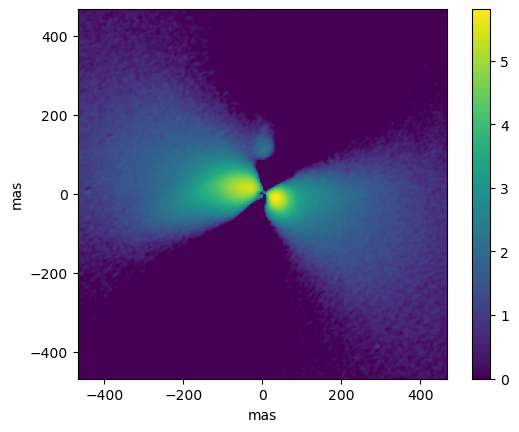

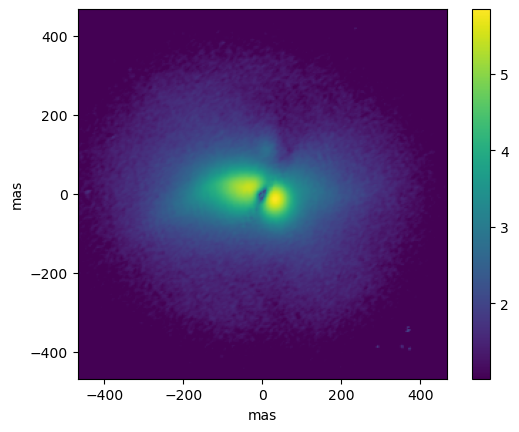

/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/ZIMPOL/
01.SCI_AR_Pup_I_Q_phi_corr_tel+unres.fits
MATCHED
1e-16
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/ZIMPOL/
01.SCI_AR_Pup_I_PI_corr_tel+unres.fits
MATCHED
0.0564287


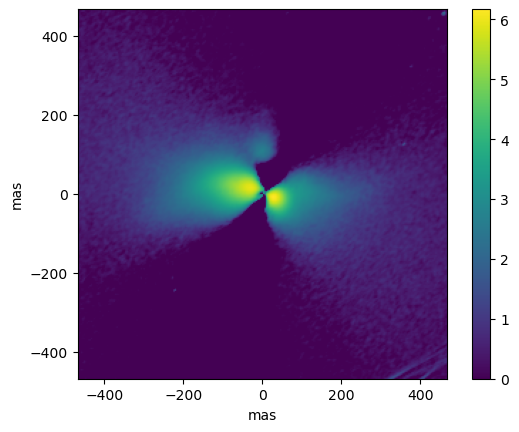

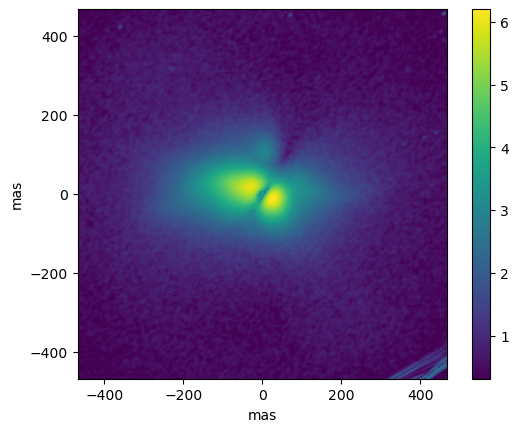

/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/After_deconv/ZIMPOL/


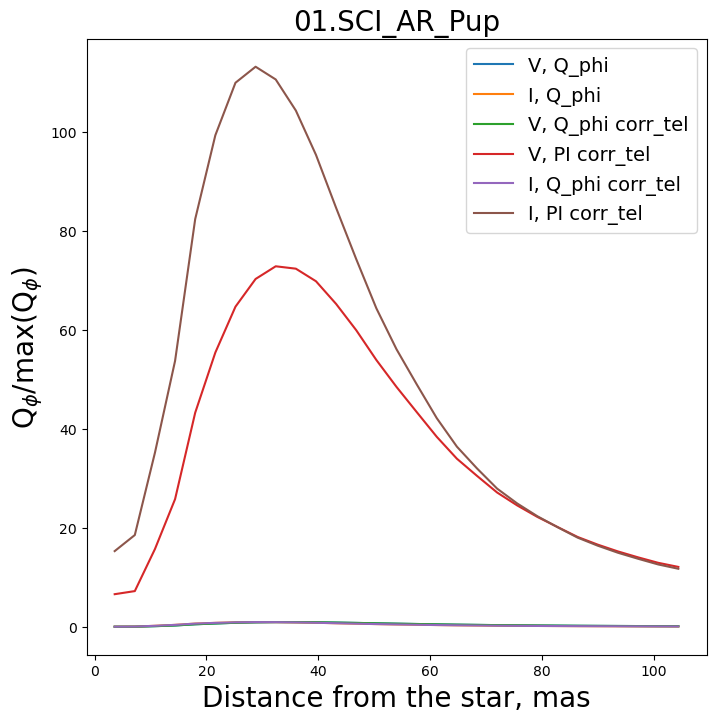

In [5]:

for fittype in fittypes:

    I=LoadImage(dirdatI,star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
    #PSF,n= Loadimagespsf('HD83878','/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/HD83878/mean_combined/',band[int(fittype)-1])

    Q_phi, n=Loadimages_notdeconv(star,'Q_phi',dirdatI,band[int(fittype)-1],'_corr_tel+unres')
    PI, n=Loadimages_notdeconv(star,'PI',dirdatI,band[int(fittype)-1],'_corr_tel+unres')
    #f_q= LoadImage('/media/kateryna/Data_Lin/PhD/Analysis and results for SPHERE_stage_2/models/psf_smearing_HD83878/',band[int(fittype)-1]+'band_qphi_ellipse_pa121_i23_f_psf_50.fits')
    #f_pi= LoadImage('/media/kateryna/Data_Lin/PhD/Analysis and results for SPHERE_stage_2/models/psf_smearing_HD83878/',band[int(fittype)-1]+'band_pi_ellipse_pa121_i23_f_psf_50.fits')

    #Q_phi=np.divide(Q_phi,f_q,where=f_q!=0)

    mask=(R<=1500/ps)
    #PSF=PSF#/np.max(PSF[mask])#*np.sum(PSF[mask])/10e6
    norm=np.max(I[mask])

    #radial_brightness

    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-xc
    yr = yr-yc
    Xr, Yr = np.meshgrid(xr, yr)
    R=np.sqrt(Xr**2 + (Yr)**2)

    I_mean_ar=[]
    #PSF_mean_ar=[]
    PI_mean_ar=[]
    PI_unres_mean_ar=[]
    Q_phi_mean_ar=[]
    Q_phi_unres_mean_ar=[]
    for i_r in range (1,30,1):

        width=math.sqrt(i_r)/2
        mask = (R < i_r+width) & (R >=(i_r-width))
        image_I=I[mask]
        image_PI=PI[mask]
        #image_PSF=PSF[mask]
        image_Q_phi=Q_phi[mask]

        i_r_stop=i_r
        I_mean=np.mean(image_I)
        #PSF_mean=np.mean(image_PSF)
        I_mean_ar.append(I_mean)
        #PSF_mean_ar.append(PSF_mean)
        PI_mean=np.mean(image_PI)
        PI_mean_ar.append(PI_mean)

        Q_phi_mean=np.mean(image_Q_phi)
        Q_phi_mean_ar.append(Q_phi_mean)
        #logfile.writelines("error = "+str(error)+'\n')
        #logfile.writelines("u_mean = "+str(u_mean)+'\n')
        #logfile.writelines("u_mean/error = "+str(u_mean/error)+'\n')
        #logfile.writelines("q_mean = "+str(q_mean)+'\n')
        #logfile.writelines("snr = "+str(snr)+'\n')
        #logfile.writelines('\n')


    # if fittype=='1':
    #     print('H')
    #     Q_phi_mean_ar_H=Q_phi_mean_ar
    #     PI_mean_ar_H=PI_mean_ar

    if fittype=='1':
        print('V')
        Q_phi_mean_ar_V=Q_phi_mean_ar
        PI_mean_ar_V=PI_mean_ar

    if fittype=='2':
        Q_phi_mean_ar_I=Q_phi_mean_ar
        PI_mean_ar_I=PI_mean_ar



    plotImage(Q_phi,130)
    plt.show()
    plt.close()
    plotImage(PI,130)
    plt.show()
    plt.close()

i_rad=[float(x)*ps for x in range (1,i_r_stop+1,1)]
    #plt.plot(i_rad,q_mean)
    #print(len(i_rad),len(q_mean_ar),len(var_ar))

fig, (ax1) = plt.subplots(1, 1,figsize=(8,8))
plt.ylabel(r'Q$_\phi$/max(Q$_\phi$)', fontsize=20)
plt.xlabel('Distance from the star, mas', fontsize=20)
#plt.yscale('log')

# change labels if doing for other stars
#  unresolved corrected
plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi')
plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi')

# +unres+PSF_smear
plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi corr_tel')
plt.plot(i_rad,PI_mean_ar_V, label='V, PI corr_tel')

plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi corr_tel')
plt.plot(i_rad,PI_mean_ar_I, label='I, PI corr_tel')

# plt.plot(i_rad,Q_phi_mean_ar_H/np.max(Q_phi_mean_ar_H), label='H, Q_phi corr_tel+unres+PSF_smear')
#plt.plot(i_rad,PI_mean_ar_H, label='H, PI corr_tel+unres+PSF_smear')

print(figfolder)

plt.title(star,fontsize=20)
plt.legend(fontsize=14)
plt.savefig(figfolder+'radial_prof_telcorr.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


In [9]:
star

'01.SCI_AR_Pup'

In [10]:
dirdatI

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/ZIMPOL/'

### PSF Smearing coefficients

In [14]:
band[int(fittype)-1]

'I'

In [15]:
band

['V', 'I']

1024
1024


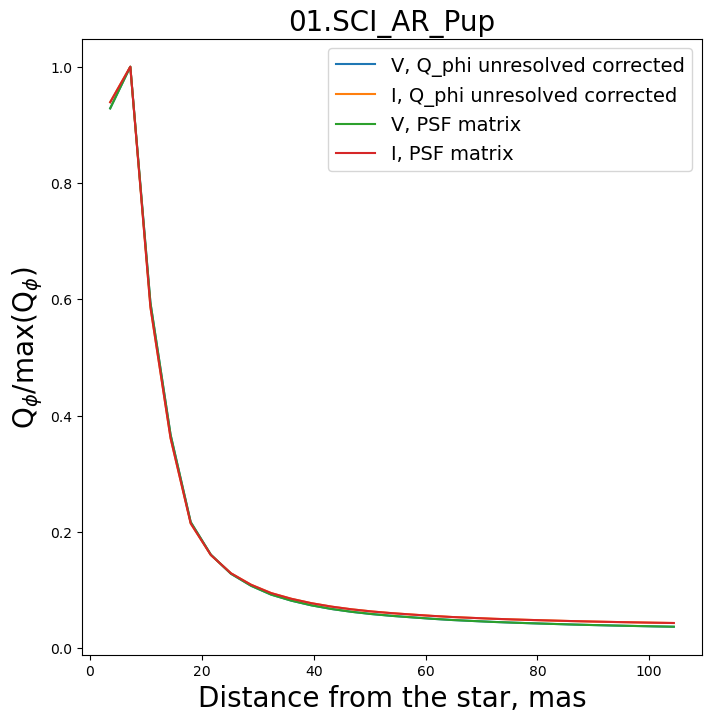

THe name is  PSF matrix


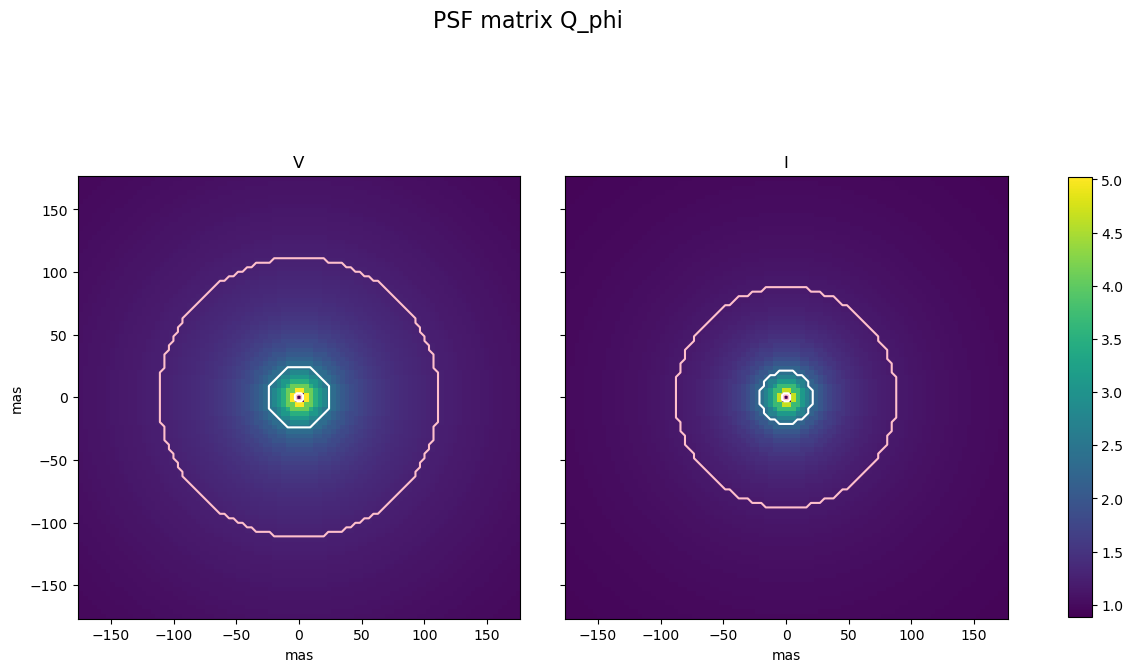

In [6]:

for fittype in fittypes:
    
    if star!='01.SCI_AR_Pup':
        f_q= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+ref_of_sci[star]+'/PSF_models/',ref_of_sci[star]+band[int(fittype)-1]+'band_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
        f_pi= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+ref_of_sci[star]+'/PSF_models/',ref_of_sci[star]+band[int(fittype)-1]+'band_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
    elif star=='01.SCI_AR_Pup':
        f_q= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+ref_of_sci[star]+'/PSF_models/',band[int(fittype)-1]+'band_qphi_circular_f_psf_50.fits')
        f_pi= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+ref_of_sci[star]+'/PSF_models/',band[int(fittype)-1]+'band_pi_circular_f_psf_50.fits')

    Q_phi=f_q
    PI=f_pi
    PSF,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/',band[int(fittype)-1])
    
    mask=(R<=1500/ps)
    #PSF=PSF#/np.max(PSF[mask])#*np.sum(PSF[mask])/10e6
    norm=np.max(I[mask])
    
    #radial_brightness

    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-xc
    yr = yr-yc
    Xr, Yr = np.meshgrid(xr, yr)            
    R=np.sqrt(Xr**2 + (Yr)**2)

    
    PI_mean_ar=[]
    Q_phi_mean_ar=[]
    for i_r in range (1,30,1):

        width=math.sqrt(i_r)/2
        mask = (R < i_r+width) & (R >=(i_r-width))
        image_PI=PI[mask]
        image_Q_phi=Q_phi[mask]
        
        i_r_stop=i_r
        PI_mean=np.mean(image_PI)
        PI_mean_ar.append(PI_mean)
       
        Q_phi_mean=np.mean(image_Q_phi)
        Q_phi_mean_ar.append(Q_phi_mean)
        # logfile.writelines("error = "+str(error)+'\n')
        # logfile.writelines("u_mean = "+str(u_mean)+'\n')
        # logfile.writelines("u_mean/error = "+str(u_mean/error)+'\n')
        # logfile.writelines("q_mean = "+str(q_mean)+'\n')
        # logfile.writelines("snr = "+str(snr)+'\n')
        # logfile.writelines('\n')

    # if fittype=='1':
    #         print('H')
    #         Q_phi_mean_ar_V=Q_phi_mean_ar
    #         PI_mean_ar_V=PI_mean_ar

    if fittype=='1':
        Q_phi_mean_ar_V=Q_phi_mean_ar
        PI_mean_ar_V=PI_mean_ar
        
    if fittype=='2':
        Q_phi_mean_ar_I=Q_phi_mean_ar
        PI_mean_ar_I=PI_mean_ar
        
i_rad=[float(x)*ps for x in range (1,i_r_stop+1,1)]    
    #plt.plot(i_rad,q_mean)
    #print(len(i_rad),len(q_mean_ar),len(var_ar))

fig, (ax1) = plt.subplots(1, 1,figsize=(8,8))
plt.ylabel(r'Q$_\phi$/max(Q$_\phi$)', fontsize=20)
plt.xlabel('Distance from the star, mas', fontsize=20)
#plt.yscale('log')

plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi unresolved corrected')
plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi unresolved corrected')

plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, PSF matrix')
plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, PSF matrix')
plt.title(star,fontsize=20)
plt.legend(fontsize=14)
plt.savefig(figfolder+'radial_prof_PSF.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

#CHANGE
if star!='01.SCI_AR_Pup':
    f_qV= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+ref_of_sci[star]+'/PSF_models/',ref_of_sci[star]+'V'+'band_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
    f_qI= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+ref_of_sci[star]+'/PSF_models/',ref_of_sci[star]+'I'+'band_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
    
elif star=='01.SCI_AR_Pup':
    f_qV= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+ref_of_sci[star]+'/PSF_models/',"V"+'band_qphi_circular_f_psf_50.fits')
    f_qI= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+ref_of_sci[star]+'/PSF_models/',"I"+'band_qphi_circular_f_psf_50.fits')
        
#f_qV= LoadImage('/media/kateryna/Data_Lin/PhD/Analysis and results for SPHERE_stage_2/models/psf_smearing_HD83878/','V'+'band_qphi_ellipse_pa121_i23_f_psf_50.fits')
#f_qI= LoadImage('/media/kateryna/Data_Lin/PhD/Analysis and results for SPHERE_stage_2/models/psf_smearing_HD83878/','I'+'band_qphi_ellipse_pa121_i23_f_psf_50.fits')
        

#
keys=['V','I']
labels={'V':'V','I':'I'}
data={'V': f_qV ,'I':f_qI}
cameras=['ZIMPOL','ZIMPOL']
plot_with_same_color(data, keys, labels ,'Q_phi','PSF matrix',4*ps,True,cameras)

# keys=['H']
# labels={'H':'H'}
# data={'H': f_qV}
# cameras=['IRDIS']
# plot_with_same_color(data, keys, labels ,'Q_phi','PSF matrix',4*ps,True,cameras)
plt.savefig(figfolder+band[int(fittype)-1]+'band_qphi_decon+PSF_smear.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


In [17]:
f_q

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], shape=(1024, 1024), dtype='>f8')

### Deconvolved (only)

1024


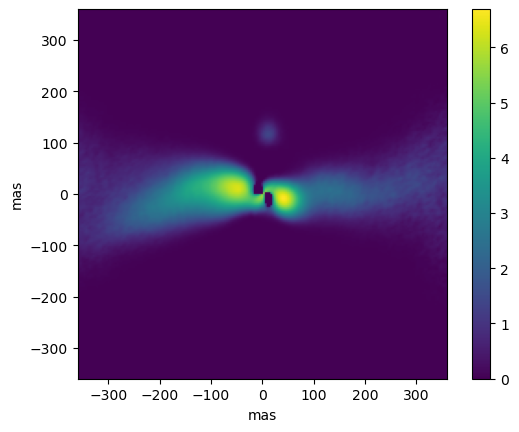

1024


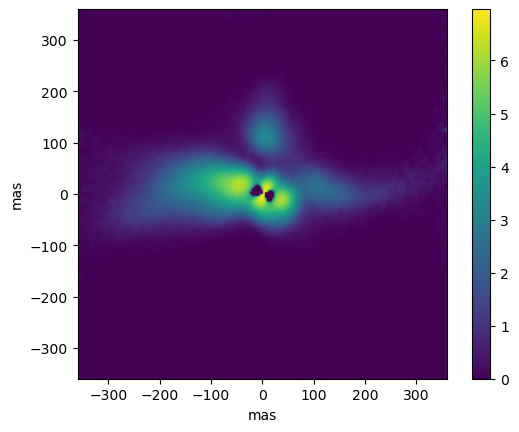

/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/After_deconv/ZIMPOL/


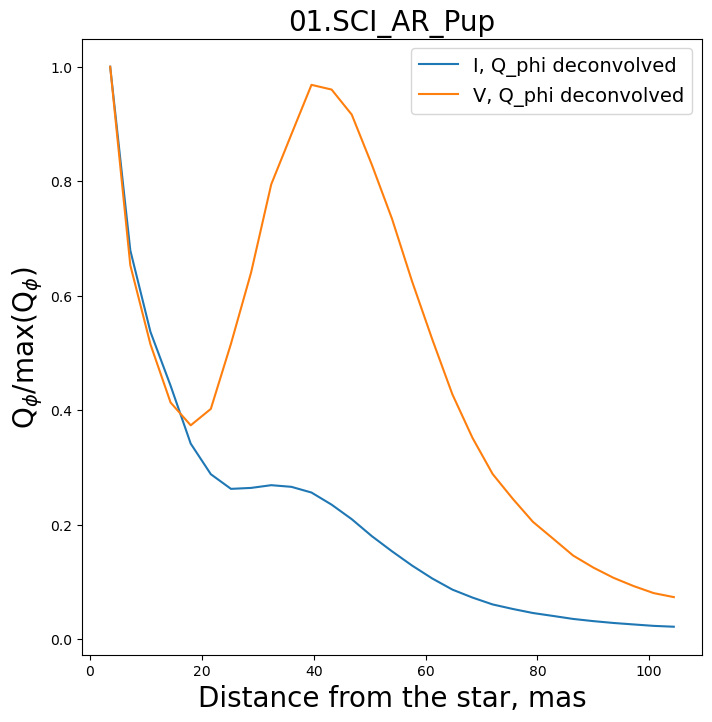

In [7]:
for fittype in fittypes:
    
    I=LoadImage(dirdatI,star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
    PSF,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/',band[int(fittype)-1])
    dir =dirdat +'/deconvolved_'+'Q_phi'+'/' 
    Q_phi, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
    dir =dirdat +'/deconvolved_'+'PI'+'/'
    PI, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
        
    mask=(R<=1500/ps)
    PSF=PSF#/np.max(PSF[mask])#*np.sum(PSF[mask])/10e6
    norm=np.max(I[mask])
    
    #radial_brightness

    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-xc
    yr = yr-yc
    Xr, Yr = np.meshgrid(xr, yr)            
    R=np.sqrt(Xr**2 + (Yr)**2)

    I_mean_ar=[]
    PSF_mean_ar=[]
    PI_mean_ar=[]
    PI_unres_mean_ar=[]
    Q_phi_mean_ar=[]
    Q_phi_unres_mean_ar=[]
    for i_r in range (1,30,1):

        width=math.sqrt(i_r)/2
        mask = (R < i_r+width) & (R >=(i_r-width))
        image_I=I[mask]
        image_PI=PI[mask]
        image_PSF=PSF[mask]
        image_Q_phi=Q_phi[mask]
        
        i_r_stop=i_r
        I_mean=np.mean(image_I)
        PSF_mean=np.mean(image_PSF)
        I_mean_ar.append(I_mean)
        PSF_mean_ar.append(PSF_mean)
        PI_mean=np.mean(image_PI)
        PI_mean_ar.append(PI_mean)
       
        Q_phi_mean=np.mean(image_Q_phi)
        Q_phi_mean_ar.append(Q_phi_mean)
        #logfile.writelines("error = "+str(error)+'\n')
        #logfile.writelines("u_mean = "+str(u_mean)+'\n')
        #logfile.writelines("u_mean/error = "+str(u_mean/error)+'\n')
        #logfile.writelines("q_mean = "+str(q_mean)+'\n')
        #logfile.writelines("snr = "+str(snr)+'\n')
        #logfile.writelines('\n')

    # if fittype=='1':
        # print('H')
        # Q_phi_mean_ar_H=Q_phi_mean_ar
        # PI_mean_ar_H=PI_mean_ar

    if fittype=='1':
        Q_phi_mean_ar_V=Q_phi_mean_ar
        PI_mean_ar_V=PI_mean_ar
        
    if fittype=='2':
        Q_phi_mean_ar_I=Q_phi_mean_ar
        PI_mean_ar_I=PI_mean_ar
    
    plotImage(Q_phi,100)
    plt.show()
    plt.close()  

i_rad=[float(x)*ps for x in range (1,i_r_stop+1,1)]    
    #plt.plot(i_rad,q_mean)
    #print(len(i_rad),len(q_mean_ar),len(var_ar))

fig, (ax1) = plt.subplots(1, 1,figsize=(8,8))
plt.ylabel(r'Q$_\phi$/max(Q$_\phi$)', fontsize=20)
plt.xlabel('Distance from the star, mas', fontsize=20)
#plt.yscale('log')


# plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi unresolved corrected')
# plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi unresolved corrected')
# plt.plot(i_rad,Q_phi_mean_ar_H/np.max(Q_phi_mean_ar_H), label='H, Q_phi deconvolved')

# plt.plot(i_rad,PI_mean_ar_V, label='V, PI deconvolved')
# plt.plot(i_rad,PI_mean_ar_I, label='I, PI deconvolved')
# plt.plot(i_rad,PI_mean_ar_H, label='H, PI deconvolved')

plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi deconvolved')
plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi deconvolved')
# # plt.plot(i_rad,Q_phi_mean_ar_H/np.max(Q_phi_mean_ar_H), label='H, Q_phi deconvolved')

print(figfolder)
plt.title(star,fontsize=20)
# plt.plot(i_rad,PI_mean_ar_I, label='I, PI deconvolved')
plt.legend(fontsize=14)
plt.savefig(figfolder+'Qphi_radial_prof_deconv.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


In [22]:
figfolder

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/After_deconv/ZIMPOL/'

In [43]:
fittypes

['1', '2']

### Deconvolved+PSF smearing

1024


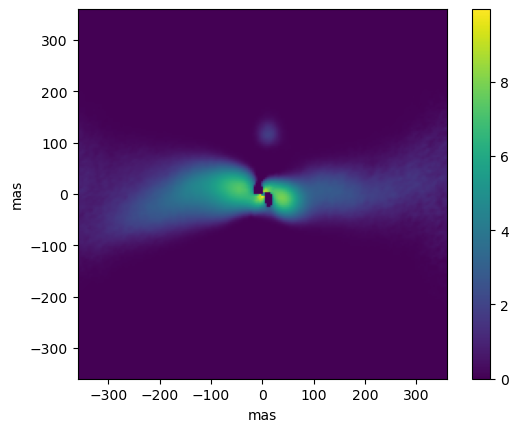

1024


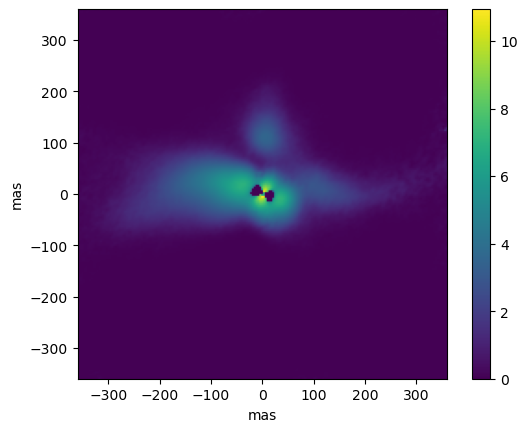

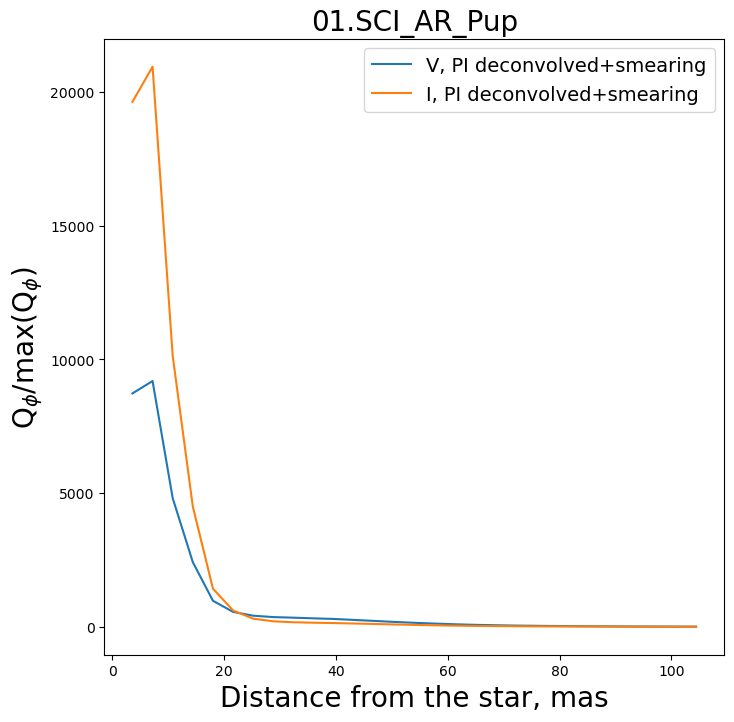

In [8]:

dirdat='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/'

for fittype in fittypes:
    
    I=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
    PSF,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/',band[int(fittype)-1])
    PI, n=Loadimages(dirdat0,band[int(fittype)-1],'band_pi_decon+PSF_smear')
    Q_phi, n=Loadimages(dirdat0,band[int(fittype)-1],'band_qphi_decon+PSF_smear')
    
        
    mask=(R<=1500/ps)
    PSF=PSF#/np.max(PSF[mask])#*np.sum(PSF[mask])/10e6
    norm=np.max(I[mask])
    
    #radial_brightness

    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-xc
    yr = yr-yc
    Xr, Yr = np.meshgrid(xr, yr)            
    R=np.sqrt(Xr**2 + (Yr)**2)

    I_mean_ar=[]
    PSF_mean_ar=[]
    PI_mean_ar=[]
    PI_unres_mean_ar=[]
    Q_phi_mean_ar=[]
    Q_phi_unres_mean_ar=[]
    for i_r in range (1,30,1):

        width=math.sqrt(i_r)/2
        mask = (R < i_r+width) & (R >=(i_r-width))
        image_I=I[mask]
        image_PI=PI[mask]
        image_PSF=PSF[mask]
        image_Q_phi=Q_phi[mask]
        
        i_r_stop=i_r
        I_mean=np.mean(image_I)
        PSF_mean=np.mean(image_PSF)
        I_mean_ar.append(I_mean)
        PSF_mean_ar.append(PSF_mean)
        PI_mean=np.mean(image_PI)
        PI_mean_ar.append(PI_mean)
       
        Q_phi_mean=np.mean(image_Q_phi)
        Q_phi_mean_ar.append(Q_phi_mean)
        #logfile.writelines("error = "+str(error)+'\n')
        #logfile.writelines("u_mean = "+str(u_mean)+'\n')
        #logfile.writelines("u_mean/error = "+str(u_mean/error)+'\n')
        #logfile.writelines("q_mean = "+str(q_mean)+'\n')
        #logfile.writelines("snr = "+str(snr)+'\n')
        #logfile.writelines('\n')


    # if fittype=='1':
    #     print('H')
    #     Q_phi_mean_ar_H=Q_phi_mean_ar
    #     PI_mean_ar_H=PI_mean_ar

    if fittype=='1':
        Q_phi_mean_ar_V=Q_phi_mean_ar
        PI_mean_ar_V=PI_mean_ar
        
    if fittype=='2':
        Q_phi_mean_ar_I=Q_phi_mean_ar
        PI_mean_ar_I=PI_mean_ar
        
    plotImage(Q_phi,100)
    plt.show()
    plt.close()   
    
i_rad=[float(x)*ps for x in range (1,i_r_stop+1,1)]    
    #plt.plot(i_rad,q_mean)
    #print(len(i_rad),len(q_mean_ar),len(var_ar))

fig, (ax1) = plt.subplots(1, 1,figsize=(8,8))
plt.ylabel(r'Q$_\phi$/max(Q$_\phi$)', fontsize=20)
plt.xlabel('Distance from the star, mas', fontsize=20)
#plt.yscale('log')


# plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi unresolved corrected')
# plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi unresolved corrected')
# plt.plot(i_rad,Q_phi_mean_ar_H/np.max(Q_phi_mean_ar_H), label='H, Q_phi unresolved corrected')

# plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi deconvolved+smearing')
# plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi deconvolved+smearing')
# plt.plot(i_rad,Q_phi_mean_ar_H/np.max(Q_phi_mean_ar_H), label='H, Q_phi deconvolved+smearing')


plt.plot(i_rad,PI_mean_ar_V, label='V, PI deconvolved+smearing')
plt.plot(i_rad,PI_mean_ar_I, label='I, PI deconvolved+smearing')
# plt.plot(i_rad,PI_mean_ar_H, label='H, PI deconvolved+smearing')

plt.title(star,fontsize=20)
plt.legend(fontsize=14)
plt.savefig(figfolder+'PI_radial_prof_deconv_PSF.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


## Attempt to get percentage of scattered light using reference PSF

In [26]:
ref_of_sci[star]

'REF_HD75885'

1024
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/ZIMPOL/
01.SCI_AR_Pup_V_Q_phi_corr_tel+unres.fits
MATCHED
1e-16


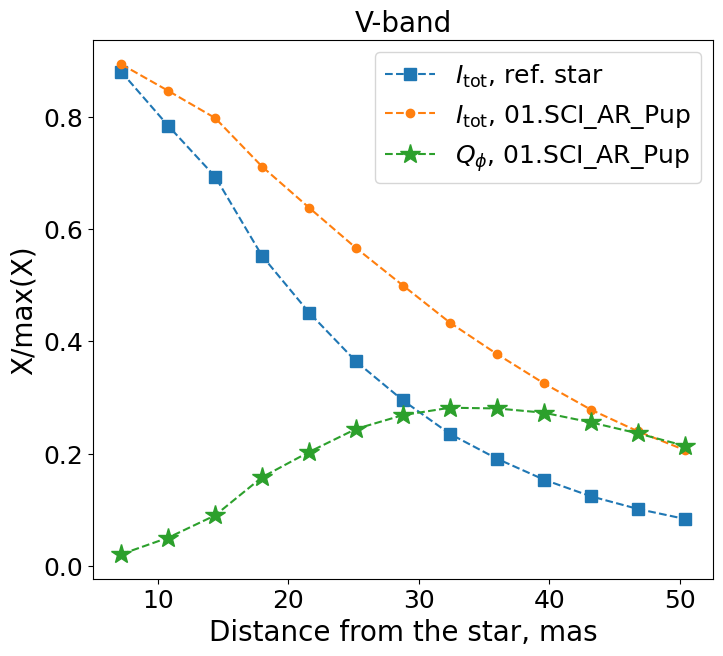

for pixel to pixel I-PSF  % 6.191925353008643
1024
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/ZIMPOL/
01.SCI_AR_Pup_I_Q_phi_corr_tel+unres.fits
MATCHED
1e-16


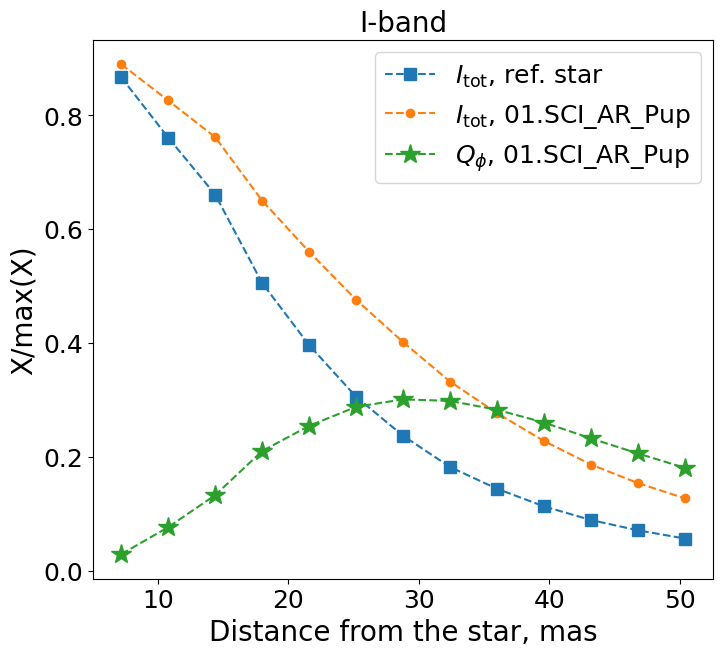

for pixel to pixel I-PSF  % 10.228344511259637


In [9]:
def Loadimagespsf(star,dirdat,band):
    dir = dirdat
    qfile = '*_'+band+'_I_meancombined.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

                print(n)
    return image, n

def Loadimages(star,fittype,dirdat,band, extension):
    dir = dirdat
    qfile = '*'+band+'_'+fittype+extension+'.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):

            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

    return image, n

def plotImage(image, lim):
    n = image.shape[0]

    fig, ax = plt.subplots(figsize=(8,6))
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas',fontsize=18)
    plt.ylabel("mas",fontsize=18)
    plt.colorbar()

import functions as f

dirdat0 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/After_deconv/'+camera+'/'

dirdat='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/'
figfolder = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/scattered/'+camera+'/'
create_dir(figfolder)

#dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/corr_with_ref/tel+unresol+PSF_smearing/Andrych2023/'  #For IRAS08
xc=511.5
yc=511.5

for fittype in fittypes:

    I=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')

    # CHANGE REFERENCE STAR, depending on IRDIS/ZIMPOL observations
    PSF,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr_Ref/'+camera+'/',band[int(fittype)-1])

    PI_unres, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_corr_'+'tel+unres')
    PI=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'PI'+'_meancombined.fits')
    Qphi, n=Loadimages_notdeconv(star,'Q_phi',dirdatI,band[int(fittype)-1],'_corr_tel+unres')

    mask=(R<=500/ps)
    PSF=PSF#$/np.sum(PSF[mask])*10e6
    #print(np.max(I[mask]))
    #print(np.max(PI[mask]))


    norm=np.max(PI[mask])
    #PSF=PSF*norm

    I=I/np.max(I[mask])
    PSF=PSF/np.max(PSF[mask])
    #I=I/norm
    PI=PI/norm
    Qphi=Qphi/np.max(Qphi)
    #PI_unres=PI_unres/norm

    #radial_brightness
    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-xc
    yr = yr-yc
    Xr, Yr = np.meshgrid(xr, yr)
    R=np.sqrt(Xr**2 + (Yr)**2)
    r, pos_angle = f.cart2polar_for_mask_defining(Xr, Yr)
    pos_angle=np.rad2deg(pos_angle)+180

    I_mean_ar=[]
    PSF_mean_ar=[]
    PI_mean_ar=[]
    PI_unres_mean_ar=[]
    Qphi_mean_ar=[]
    for i_r in range (2,15,1):

        width=math.sqrt(i_r)/2
        mask = (R < i_r+width) & (R >=(i_r-width))# & (pos_angle>startang)& (pos_angle<endang)
        image_I=I[mask]
        image_PI=PI[mask]
        image_PSF=PSF[mask]
        image_PI_unres=PI_unres[mask]
        image_Qphi=Qphi[mask]

        i_r_stop=i_r
        I_mean=np.mean(image_I)
        PSF_mean=np.mean(image_PSF)
        I_mean_ar.append(I_mean)
        PSF_mean_ar.append(PSF_mean)
        PI_mean=np.mean(image_PI)
        PI_mean_ar.append(PI_mean)
        PI_unres_mean=np.mean(image_PI_unres)
        PI_unres_mean_ar.append(PI_unres_mean)
        Qphi_mean=np.mean(image_Qphi)
        Qphi_mean_ar.append(Qphi_mean)

    i_rad=[float(x)*ps for x in range (2,i_r_stop+1,1)]
    #plt.plot(i_rad,q_mean)
    #print(len(i_rad),len(q_mean_ar),len(var_ar))

    fig, (ax1) = plt.subplots(1, 1,figsize=(8,7))
    plt.errorbar(i_rad,PSF_mean_ar, label=r'$I_{\rm tot}$, ref. star',fmt='--s', markersize=8)
    plt.errorbar(i_rad,I_mean_ar, label=r'$I_{\rm tot}$, '+star, fmt='--o')
    # plt.errorbar(i_rad,PI_mean_ar, label='PI, IRAS08544-4431', fmt='--o')
    plt.errorbar(i_rad,Qphi_mean_ar, label=r'$Q_{\phi}$, '+star, fmt='--*', markersize=15)
    plt.ylabel(r'X/max(X)', fontsize=20)
    plt.xlabel('Distance from the star, mas', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(band[int(fittype)-1]+'-band',fontsize=20)
    plt.legend(fontsize=18)
    #plt.yscale('log')

    plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_scattered.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

    scattered=I-PSF
    scattered_pos=scattered*(scattered>=0)+1e-15*(scattered<0)

    Iscat_full=np.sum(scattered_pos*(R<=i_r))/np.sum(I*(R<=1500/ps))
    print('for pixel to pixel I-PSF  %',Iscat_full*100)


## Check difference between PI and Qphi

1024
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/ZIMPOL/
01.SCI_AR_Pup_V_Q_phi_corr_tel+unres.fits
MATCHED
1e-16


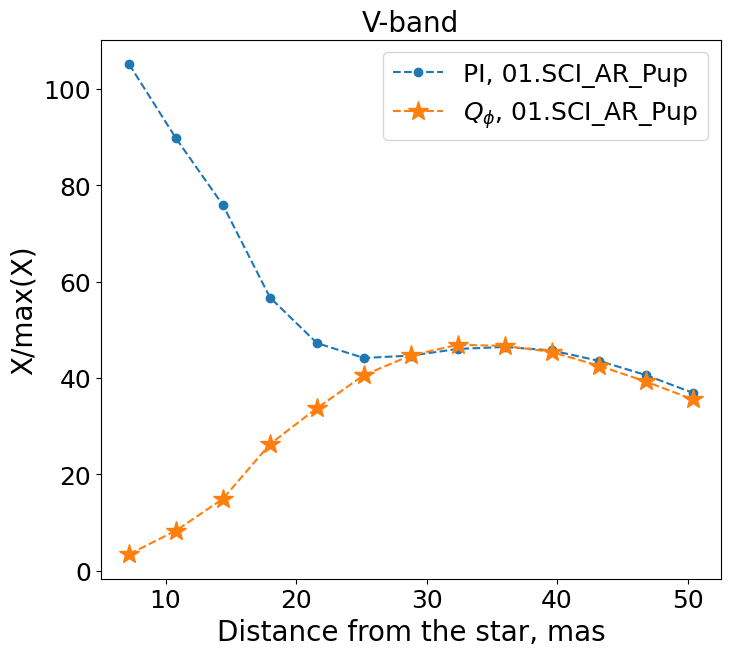

1024
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/ZIMPOL/
01.SCI_AR_Pup_I_Q_phi_corr_tel+unres.fits
MATCHED
1e-16


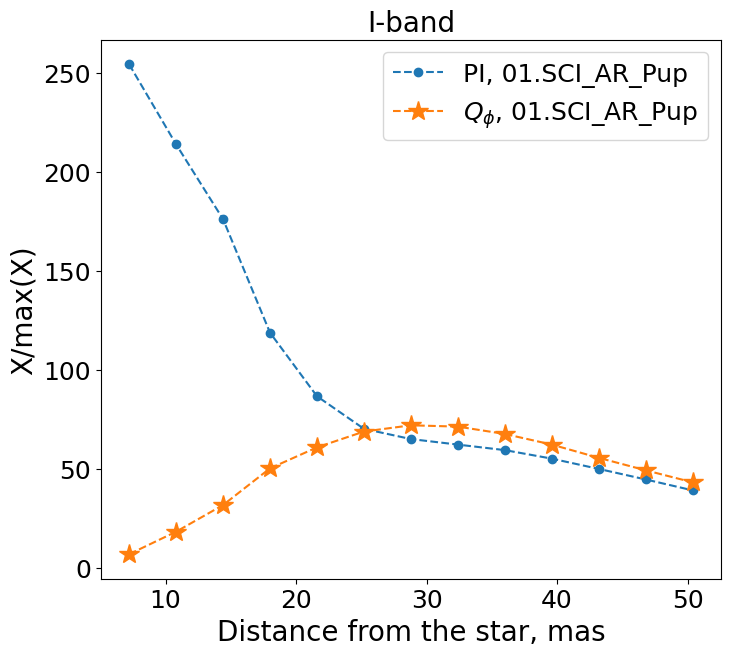

In [10]:
def Loadimagespsf(star,dirdat,band):
    dir = dirdat
    qfile = '*_'+band+'_I_meancombined.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

                print(n)
    return image, n

def Loadimages(star,fittype,dirdat,band, extension):
    dir = dirdat
    qfile = '*'+band+'_'+fittype+extension+'.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]
                
    return image, n

def plotImage(image, lim):
    n = image.shape[0]
    
    fig, ax = plt.subplots(figsize=(8,6))
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas',fontsize=18)
    plt.ylabel("mas",fontsize=18)
    plt.colorbar()
    
import functions as f

dirdat0 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/After_deconv/'+camera+'/'
dirdat='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/'
figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/scattered/'+camera+'/'


#dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/corr_with_ref/tel+unresol+PSF_smearing/Andrych2023/'  #For IRAS08
xc=511.5
yc=511.5

for fittype in fittypes:
    
    I=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')

    # CHANGE REFERENCES DIRECTORY AS NEEDED
    PSF,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr_Ref/'+camera+'/',band[int(fittype)-1])

    PI_unres, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_corr_'+'tel+unres')
    PI=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'PI'+'_meancombined.fits')
    Qphi, n=Loadimages_notdeconv(star,'Q_phi',dirdatI,band[int(fittype)-1],'_corr_tel+unres')
    
    mask=(R<=500/ps)
    PSF=PSF#$/np.sum(PSF[mask])*10e6
    #print(np.max(I[mask]))
    #print(np.max(PI[mask]))
    
    
    norm=np.max(PI[mask])
    #PSF=PSF*norm
    
    I=I/np.max(I[mask])
    PSF=PSF/np.max(PSF[mask])
    #I=I/norm
    #PI=PI/norm
    #Qphi=Qphi/np.max(Qphi)
    #PI_unres=PI_unres/norm

    #radial_brightness

    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-xc
    yr = yr-yc
    Xr, Yr = np.meshgrid(xr, yr)            
    R=np.sqrt(Xr**2 + (Yr)**2)
    r, pos_angle = f.cart2polar_for_mask_defining(Xr, Yr)
    pos_angle=np.rad2deg(pos_angle)+180
    

    I_mean_ar=[]
    PSF_mean_ar=[]
    PI_mean_ar=[]
    PI_unres_mean_ar=[]
    Qphi_mean_ar=[]

    for i_r in range (2,15,1):

        width=math.sqrt(i_r)/2
        mask = (R < i_r+width) & (R >=(i_r-width))# & (pos_angle>startang)& (pos_angle<endang)
        image_I=I[mask]
        image_PI=PI[mask]
        image_PSF=PSF[mask]
        image_PI_unres=PI_unres[mask]
        image_Qphi=Qphi[mask]
        

        i_r_stop=i_r
        I_mean=np.mean(image_I)
        PSF_mean=np.mean(image_PSF)
        I_mean_ar.append(I_mean)
        PSF_mean_ar.append(PSF_mean)
        PI_mean=np.mean(image_PI)
        PI_mean_ar.append(PI_mean)
        PI_unres_mean=np.mean(image_PI_unres)
        PI_unres_mean_ar.append(PI_unres_mean)
        Qphi_mean=np.mean(image_Qphi)
        Qphi_mean_ar.append(Qphi_mean)




    i_rad=[float(x)*ps for x in range (2,i_r_stop+1,1)]    
    #plt.plot(i_rad,q_mean)
    #print(len(i_rad),len(q_mean_ar),len(var_ar))

    fig, (ax1) = plt.subplots(1, 1,figsize=(8,7))
    plt.errorbar(i_rad,PI_mean_ar, label='PI, '+star, fmt='--o')
    plt.errorbar(i_rad,Qphi_mean_ar, label=r'$Q_{\phi}$, '+star, fmt='--*', markersize=15)
    plt.ylabel(r'X/max(X)', fontsize=20)
    plt.xlabel('Distance from the star, mas', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(band[int(fittype)-1]+'-band',fontsize=20)
    plt.legend(fontsize=18)
    #plt.yscale('log')

    plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_PI_Qphi.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
